$\frac{\partial u}{\partial t}=\frac{\partial^2 u}{\partial x^2}+a\left(u-u^3\right),\quad a = 1$

In [17]:
import matplotlib.pyplot as plt

# General imports
import numpy as np
import torch

# DeePyMoD imports
from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.data.burgers import burgers_delta
from deepymod.model.constraint import LeastSquares
from deepymod.model.func_approx import NN
from deepymod.model.library import Library1D
from deepymod.model.sparse_estimators import Threshold
from deepymod.training import train
from deepymod.training.sparsity_scheduler import Periodic, TrainTest, TrainTestPeriodic
from scipy.io import loadmat
import pysindy as ps

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda


In [18]:
data = np.load("../../SGA-PDE/data/chafee_infante_CI.npy", allow_pickle=True)
x = np.load("../../SGA-PDE/data/chafee_infante_x.npy", allow_pickle=True)
t = np.load("../../SGA-PDE/data/chafee_infante_t.npy", allow_pickle=True)
data.shape, x.shape, t.shape

array = {}
array["x"], array["t"] = np.meshgrid(x, t, indexing="ij")
array["u"] = data
array["x"].shape, array["t"].shape, array["u"].shape

((301, 200), (301, 200), (301, 200))

In [19]:
def load_data():
    data = np.load("../../SGA-PDE/data/chafee_infante_CI.npy", allow_pickle=True)
    x = np.load("../../SGA-PDE/data/chafee_infante_x.npy", allow_pickle=True)
    t = np.load("../../SGA-PDE/data/chafee_infante_t.npy", allow_pickle=True)
    data.shape, x.shape, t.shape

    array = {}
    array["x"], array["t"] = np.meshgrid(x, t, indexing="ij")
    array["u"] = data
    coords = torch.from_numpy(np.stack((array["t"],array["x"]), axis=-1)).float()
    data = torch.from_numpy(np.real(array["u"])).unsqueeze(-1).float()
    return coords, data

In [26]:
dataset = Dataset(
    load_data,
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 300000},
    device=device,
)

Preprocessing data
Dataset is using device:  cuda


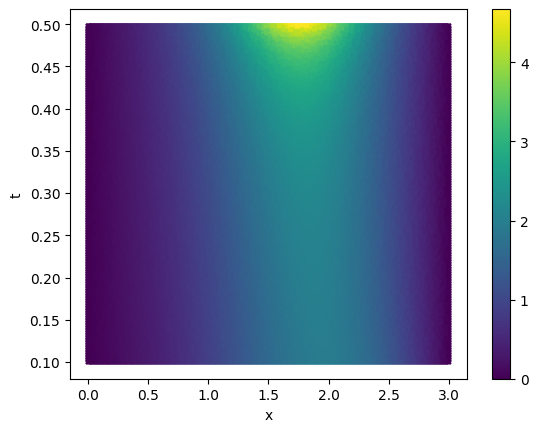

In [27]:
coords = dataset.get_coords().cpu()
data = dataset.get_data().cpu()
fig, ax = plt.subplots()
im = ax.scatter(coords[:,1], coords[:,0], c=data[:,0], marker="x", s=10)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)

plt.show()

In [28]:
coords.shape, data.shape

(torch.Size([60200, 2]), torch.Size([60200, 1]))

In [7]:
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

In [8]:
network = NN(2, [50, 50, 50, 50], 1)

In [9]:
library = Library1D(poly_order=3, diff_order=2) 

In [10]:
estimator = Threshold(0.05) 
sparsity_scheduler = TrainTestPeriodic() 

In [11]:
constraint = LeastSquares() 
# Configuration of the sparsity scheduler

In [12]:
model = DeepMoD(network, library, estimator, constraint).to(device)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3) 


In [13]:
%%time
!rm -rf ./data/deepymod/Chafee_Infante/
foldername = "./data/deepymod/Chafee_Infante/"
train(model, 
train_dataloader, 
test_dataloader, 
optimizer,
sparsity_scheduler, 
log_dir=foldername, 
split=0.8, 
max_iterations=100000) 

  7800  MSE: 8.52e-04  Reg: 2.53e-04  L1: 1.24e+01 Algorithm converged. Writing model to disk.
CPU times: user 5min 49s, sys: 5.46 s, total: 5min 55s
Wall time: 5min 51s


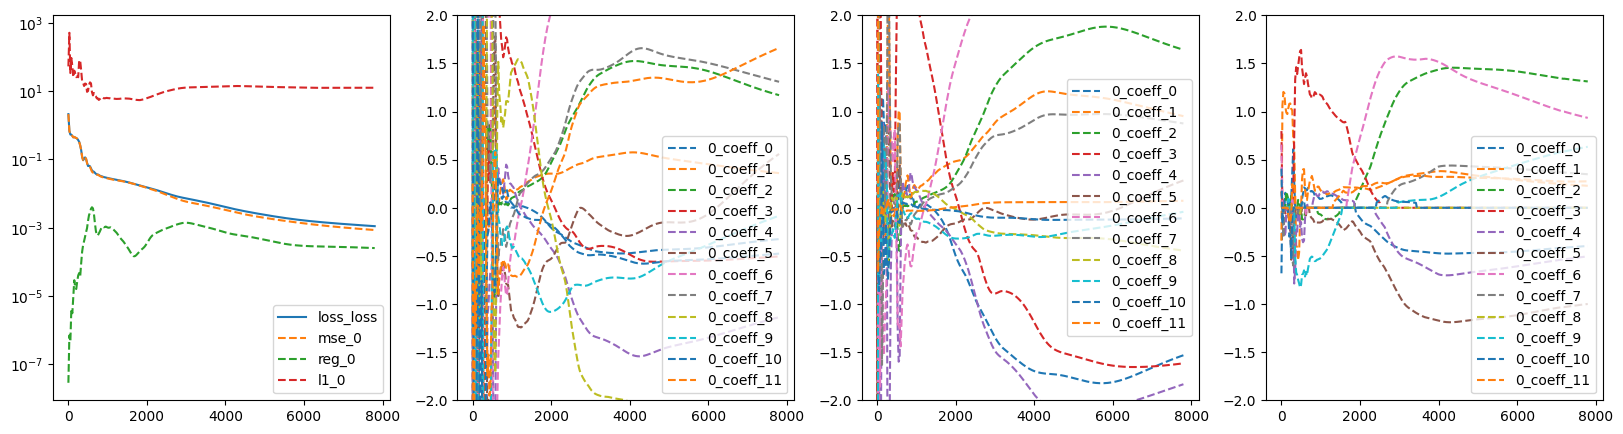

In [14]:
from deepymod.analysis import plot_history
plot_history(foldername)


* [$1, u_x, u_{xx}, u, u u_{x}, u u_{xx}, u^2, u^2 u_{x}, u^2 u_{xx}, u^3, u^3 u_{x}, u^3 u_{xx}$]

In [15]:
model.constraint_coeffs()

[tensor([[-1.5322],
         [ 0.9521],
         [ 1.6414],
         [-1.6161],
         [-1.8334],
         [ 0.2837],
         [ 2.8050],
         [ 0.8763],
         [-0.4454],
         [-0.0417],
         [-0.1103],
         [ 0.0728]], device='cuda:0', grad_fn=<MulBackward0>)]

In [16]:
model.estimator_coeffs()

[array([[-0.39721426],
        [ 0.22826709],
        [ 1.3126007 ],
        [ 0.        ],
        [-0.504669  ],
        [-0.9995456 ],
        [ 0.9339218 ],
        [ 0.34831634],
        [ 0.        ],
        [ 0.63384515],
        [ 0.        ],
        [ 0.2751477 ]], dtype=float32)]